In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_bloch_multivector
from qiskit.result import marginal_counts
from qiskit_aer import Aer
import numpy as np
from numpy import pi as pi

from IPython.display import Math,display

## 1. Bell Pair

The **Bell pair**, also known as the Einstein-Podolsky-Rosen (EPR) pair, is a highly correlated and maximally entangled two-qubit state. Its defining characteristic is that the measurement outcome of one qubit is perfectly correlated with that of the other, regardless of the physical distance between them. This property is crucial for many quantum communication protocols, such as **Quantum Teleportation** and **Superdense Coding**, which rely on entanglement as a resource.

To create a Bell pair, we start with two qubits in the initial state $|00\rangle$. The process involves two quantum gates:
1. **Hadamard Gate (H)**: Applied to the first qubit, this gate creates a superposition of $|0\rangle$ and $|1\rangle$, resulting in the state: $$\frac{|0\rangle + |1\rangle}{\sqrt2}|0\rangle \equiv \frac{1}{\sqrt2}(|00\rangle + |11\rangle)$$ At this point, the first qubit is in a superposition, while the second remains in the state $|0\rangle$.
2. **Controlled-NOT Gate (CNOT or CX)**: The first qubit is the control, and the second as the target. If the control qubit is in the state $|1\rangle$, the CNOT gate applies X (NOT) operation to the target qubit, flipping its state. The target qubit remains unchanged if the control qubit is in the state $|0\rangle$. This operation entangles the two qubits, resulting in the Bell state: $$\beta_{00} = \frac{1}{\sqrt2}(|00\rangle + |11\rangle)$$.

Note: The bell pair is labelled as $\beta_{00}$, this naming convention will be further explained in the context of the superdense coding protocol.
This Bell pair is the foundation for entanglement-based protocols, enabling the transfer of quantum information or the encoding of classical information in an entangled state.

In [2]:
def bell_pair(qc, control=0, target=1):
    '''
    Creates a bell pair on the quantum circuit (qc) between two specified qubits 
     
    Args:
        qc (QuantumCircuit): The quantum circuit to which the Bell pair creation process is applied.
        control (int): The index of the control qubit.
        target (int): The index of the target qubit.
    Returns:
        QuantumCircuit: The quantum circuit with the Bell pair created.
    Raises:
        Exception: If the circuit does not contain at least two qubits.
    '''
    if qc.num_qubits < 2:
        raise Exception("Atleast two qubits are required in the circuit")

    qc.h(control) 
    qc.cx(control, target)
    return qc

$$|00\rangle \xrightarrow{H \otimes I} \frac{1}{\sqrt2}(|00\rangle + |10\rangle) \xrightarrow{CX} \frac{1}{\sqrt2}(|00\rangle + |11\rangle)$$

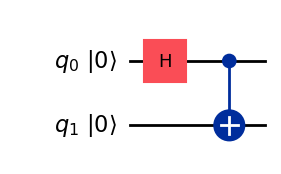

In [3]:
# Create a 2-qubit quantum cirucuit
qc = QuantumCircuit(2)

# Create a bell pair, using the custom function bell_pair
bell_pair(qc)

# Visualize the Circuit with the initial state.
qc.draw('mpl', initial_state=True)

To know the state of the quantum circuit, we can use the Statevector function

In [4]:
# Extract and display the Quantum State
state = Statevector.from_instruction(qc)
state.draw('latex')

<IPython.core.display.Latex object>

***

# 2. Quantum Teleportation

Let’s consider two parties, Alice and Bob, who share a **Bell pair**. This means Alice holds one qubit of the entangled pair, while Bob has the other. The Bell pair can be thought of as being issued by a trusted third party, ensuring that both Alice and Bob have access to their respective qubits.

In addition to her qubit from the Bell pair, Alice also possesses a qubit in an arbitrary quantum state that she wishes to send to Bob. While Alice could directly send this qubit to Bob or transmit the two parameters of the state with infinite precision via a classical channel, both options face significant practical and theoretical limitations.

**Quantum Teleportation** provides a more efficient solution: it enables Alice to "teleport" the arbitrary quantum state to Bob using only **two classical bits of information**, at the cost of consuming one shared Bell pair. This protocol demonstrates the power of quantum entanglement and classical communication in transferring quantum information.

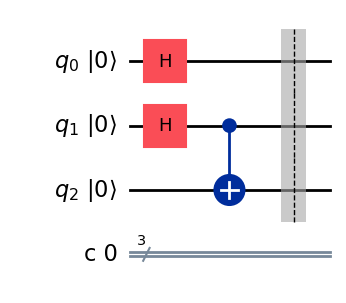

In [47]:
# Initialize a 3-qubit, 3-classical bit quantum circuit
qc = QuantumCircuit(3, 3)

# Prepare the qubit to some state
# Here, I applied a Hadarmard gate to qubit 0
qc.h(0) 

# Create a bell pair between qubits 1 and 2 using the bell_pair function
qc = bell_pair(qc, 1, 2)

qc.barrier()
qc.draw('mpl', initial_state=True) # visualize the circuit.

## Bell State Measurement

A Bell state measurement is a quantum measurement in the **Bell basis**, a set of four maximally entangled states: $$|\Phi^{\pm}\rangle =\frac{1}{\sqrt2}(|00\rangle \pm |11\rangle), \hspace{10mm} |\Psi^{\pm}\rangle = \frac{1}{\sqrt2}(|01\rangle \pm |10\rangle)$$This measurement projects the input qubits onto one of these four Bell states. It is a key component of quantum teleportation, as it allows Alice to determine how her qubits are correlated and extract the classical information needed for Bob to reconstruct the teleported state.

### Standard Basis to Bell Basis Transformation
The Bell states are related to the standard computational basis states $|00\rangle, |01\rangle, |10\rangle, |11\rangle$ through unitary transformations:
1. Apply a **CNOT gate (CX)** with the first qubit as the control and the second as the target.
2. Apply a **Hadamard gate (H)** on the first qubit.

After these gates, measuring the two qubits in the computational basis ($|00\rangle, |01\rangle, |10\rangle, |11\rangle$) effectively determines which Bell state the qubits are in. The measurement outcomes (two classical bits) correspond to the Bell state:
* $|\Phi^+\rangle \rightarrow 00$
* $|\Phi^-\rangle \rightarrow 01$
* $|\Psi^+\rangle \rightarrow 10$
* $|\Psi^-\rangle \rightarrow 11$

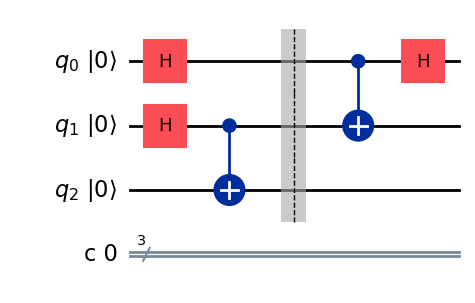

In [48]:
# These execute the unitary transformation from Bell Basis to the Standard Basis, enabling measurement in the Standard Basis
qc.cx(0, 1)
qc.h(0)
qc.draw('mpl',initial_state=True)

In [49]:
# Displays the state vector of the above quantum circuit.
state = Statevector.from_instruction(qc)
state.draw('latex')

<IPython.core.display.Latex object>

#### Measurement in the Standard Basis
The first two qubits are measured in the standard computational basis, collapsing their states and yielding two classical bits of information.

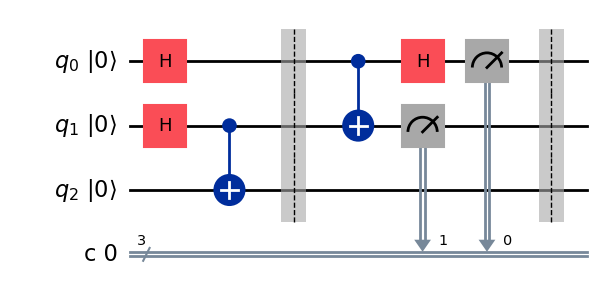

In [50]:
# Measure the first two qubits and store the results in the classical bits.
qc.measure([0, 1], [0, 1])
qc.barrier()

qc.draw('mpl',initial_state=True)

#### State Reconstruction on Bob's Qubit
Using the classical bits from the previous measurements, conditional operations are applied to the third qubit (Bob's qubit). A **CX** gate (controlled by qubit 1) and a **CZ** gate (controlled by qubit 0) reconstruct the original state. Finally, the third qubit is measured to confirm the successful teleportation of the state.

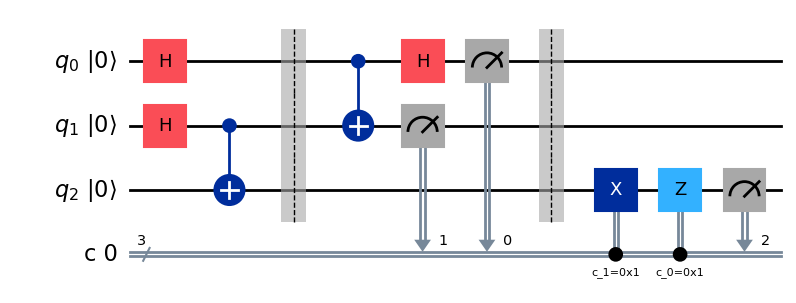

In [51]:
# Apply conditional operations to the third qubit based on the measurement outcomes with the statements below
qc.x(2).c_if(qc.clbits[1], 1.)
qc.z(2).c_if(qc.clbits[0], 1)

# Measure the third qubit to verify the reconstructed state
qc.measure(2, 2)
qc.draw('mpl', initial_state=True)

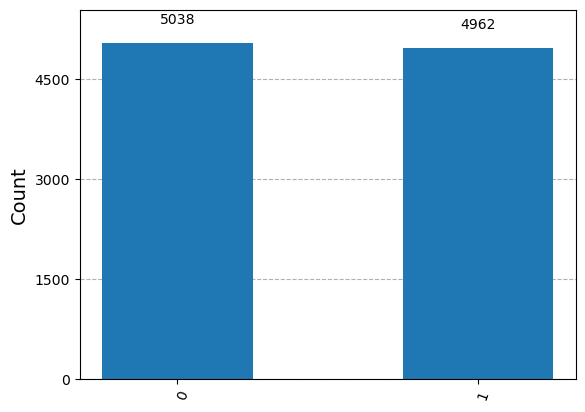

In [52]:
# Simulate the Quantum Circuit
backend = Aer.get_backend('qasm_simulator')
results = backend.run(qc, shots=10000).result()
count = results.get_counts()

# Get the counts corresponding to the qubit q2
marginal_count = marginal_counts(count , [2])

# plot the measurement counts
plot_histogram(marginal_count)

The observed counts from the experiment differ slightly from the expected theoretical values due to the finite number of shots used during simulation. As the number of shots approaches infinity, the measured probabilities will converge to the theoretical values, ensuring equal counts for states like $|+\rangle$, where the polar angle leads to an equal superposition of $|0\rangle$ + $|1\rangle$. This is a natural consequence of statistical sampling in quantum experiments and does not indicate any error in the protocol.

***

# 3. Superdense Coding

Imagine Alice and Bob, two parties who share a Bell pair. Alice wishes to send Bob 2 classical bits of information, but instead of using a classical communication channel that would require sending both bits directly, she decides to use a single qubit. At first glance, this might seem impossible—after all, a single qubit, when measured, yields only 1 classical bit of information. However, by leveraging **quantum entanglement**, Alice can achieve this remarkable feat, effectively doubling the information capacity of her qubit.

The key lies in the shared Bell pair. Entanglement establishes strong correlations between Alice's and Bob's qubits, even when separated by large distances. These correlations enable Alice to encode 2 classical bits of information into her qubit by applying specific quantum operations. After this encoding, she sends her qubit to Bob over a quantum communication channel. Bob, using his part of the Bell pair and the qubit sent by Alice, can then decode the 2 classical bits of information.

In [14]:
def encode(qc, msg, user_qubit=0):
    """
    Encodes a 2-bit classical message into the quantum circuit.

    Args:
        qc (QuantumCircuit): The quantum circuit to apply encoding to.
        msg (str): A 2-bit string representing the message (e.g., "00", "01", "10", "11").
        user_qubit (int): The index of the qubit used for encoding (default is 0).

    Returns:
        QuantumCircuit: The quantum circuit with the encoded message.
    """
    if msg[0] == "1":
        qc.x(user_qubit)
    if msg[1] == "1":
        qc.z(user_qubit)
    return qc


def decode(qc):
    """
    Decodes the quantum state to retrieve the classical message.
    Applies operations to disentangle the qubits and extract the encoded message.
    
    Args:
        qc (QuantumCircuit): The quantum circuit containing the encoded state.
        
    Returns:
        QuantumCircuit: The quantum circuit with decoding operations applied.
    """
    qc.cx(0, 1)
    qc.h(0)
    return qc


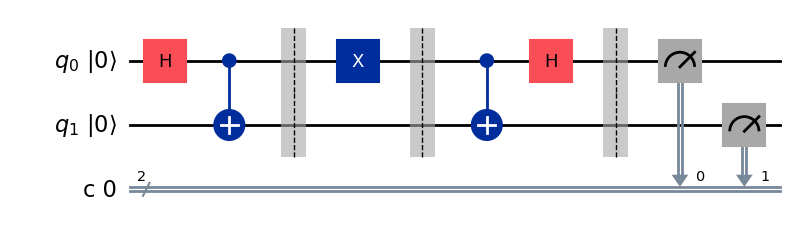

In [15]:
# Create a quantum circuit for superdense coding with 2 qubits and 2 classical bits
sdc = QuantumCircuit(2, 2)

# Create a bell pair between the 2 qubits
bell_pair(sdc)
sdc.barrier()

# Encode the classical message into the first qubit.
encode(sdc, "10")
sdc.barrier()

# Extract the state vector after encoding for analysis (optional)
sdc_state_encoded = Statevector.from_instruction(sdc)

# Decode to get the classical message
decode(sdc)
sdc.barrier()
 
# Extract the state vector after decoding for analysis (optional) 
sdc_state_decoded = Statevector.from_instruction(sdc)

# Measure both qubits to retrieve the encoded classical bits
sdc.measure([0, 1], [0, 1])
sdc.draw('mpl', initial_state=True)

In [16]:
# Display the state vectors obtained from encoding and decoding (before measurements)
display(sdc_state_encoded.draw('latex'), sdc_state_decoded.draw('latex'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

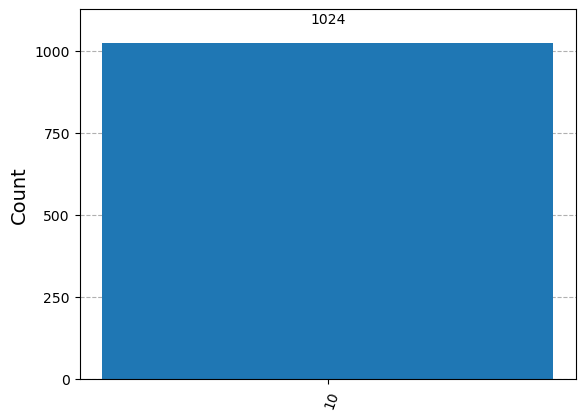

In [17]:
# Run the superdense coding circuit on the QASM simulator
results_sdc = backend.run(sdc, shots=1024).result()

# Retrieve the measurement results
counts_sdc = results_sdc.get_counts()

# Plot the histogram of the measurement outcomes
plot_histogram(counts_sdc)

***

# 4. Integration of Quantum Teleportation with Superdense Coding

The goal of this project is to explore and integrate two fundamental quantum communication protocols: **Quantum Teleportation** and **Superdense Coding**. Quantum teleportation allows the transfer of an arbitrary quantum state between two parties, Alice and Bob, using a shared Bell pair and two classical bits of information. In contrast, superdense coding demonstrates how two classical bits can be encoded into a single qubit and transmitted with an additional Bell pair.

By combining these protocols, this project showcases how quantum resources such as entanglement can be leveraged to achieve **full quantum communication**. Specifically, integrating superdense coding into the teleportation process eliminates the need for a classical transmission channel, making the entire process inherently quantum. This highlights the efficiency and potential of quantum communication, where entangled qubits can enhance the capacity and functionality of information transfer.

The project aims to provide a deeper understanding of these protocols and their synergy, emphasizing how quantum entanglement is a valuable resource for advanced communication tasks. The implementation and analysis are performed using Qiskit, showcasing the protocols' theoretical and practical aspects.

### Arbitrary State visualization

Any single-qubit pure state can be prepared using only the $R_y(\theta)$and $R_z(\phi)$ gates. These gates allow direct control over the polar angle ($\theta$) and azimuthal angle ($\phi$) of the qubit on the Bloch sphere, enabling precise state preparation.

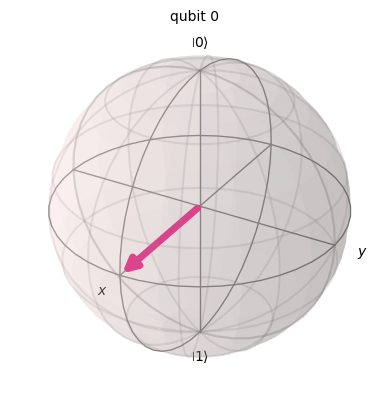

In [57]:
# Create a quantum circuit containing single qubit
arb = QuantumCircuit(1)

# Apply some rotation about the y-axis using Ry Gate.
arb.ry(pi/2, 0) # pi/2 is the polar angle

# Get the state of the qubit
arb_state = Statevector.from_instruction(arb)

# Visualize the state
plot_bloch_multivector(arb_state)

In this quantum circuit:
* The top two qubits (**q0** and **q1**) are used for the **superdense coding** protocol. q0 belongs to Alice and q1 belongs to Bob.
* The bottom two qubits (**q3** and **q4**) are used for the **quantum teleportation** protocol. q3 belongs to Alice and q4 belongs to Bob.

* The middle qubit (**q2**) holds the arbitrary state $|\psi\rangle$that we wish to teleport to Bob.

This structure ensures consistency in both protocols:
* Alice always holds the first qubit of the Bell pair (q0 for superdense coding, q3 for teleportation).
* Bob always holds the second qubit of the Bell pair (q1 for superdense coding, q4 for teleportation).

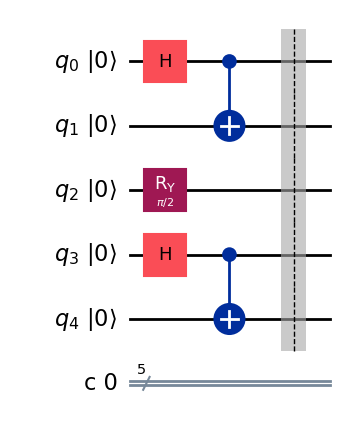

In [63]:
# Create a quantum circuit with 5 qubits and 5 classical bits
iqc = QuantumCircuit(5, 5)

# Prepare a Bell pair for the superdense coding protocol (q0 and q1)
bell_pair(iqc, 0, 1)

# Prepare a Bell pair for the quantum teleportation protocol (q3 and q4)
bell_pair(iqc, 3, 4)

# Initialize the middle qubit to some state
# This is the state that we wish to teleport to Bob
iqc.compose(arb, qubits=[2], inplace=True)

iqc.barrier()
iqc.draw("mpl", initial_state=True)

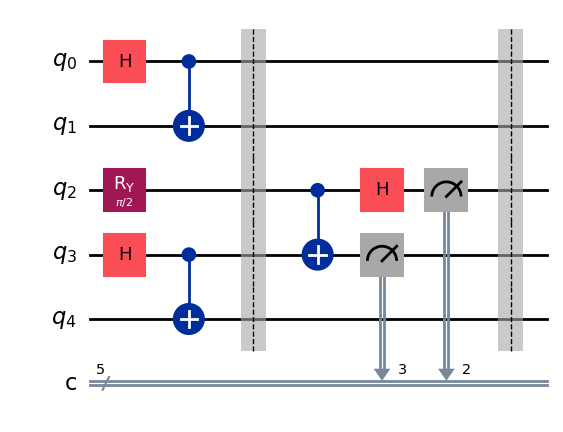

In [64]:
# Making Bell Basis Measurement
iqc.cx(2, 3)
iqc.h(2)
iqc.measure([2, 3], [2, 3])
iqc.barrier()

iqc.draw("mpl")

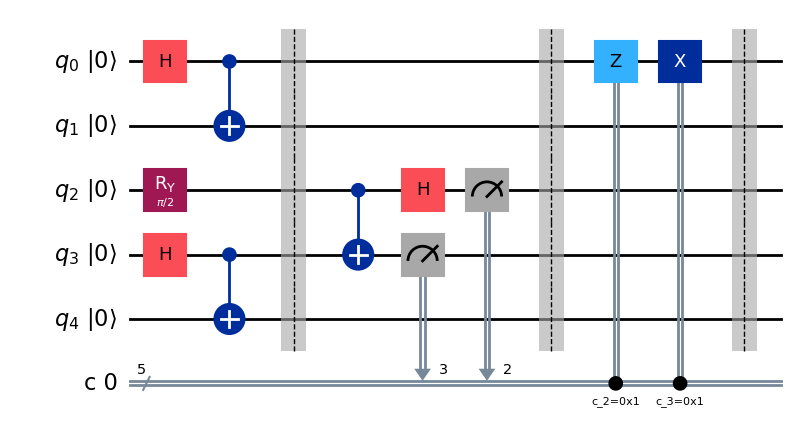

In [65]:
#Encoding the classical information using controlled operations
iqc.z(0).c_if(iqc.clbits[2], 1)
iqc.x(0).c_if(iqc.clbits[3], 1)
iqc.barrier()
iqc.draw("mpl", initial_state=True)

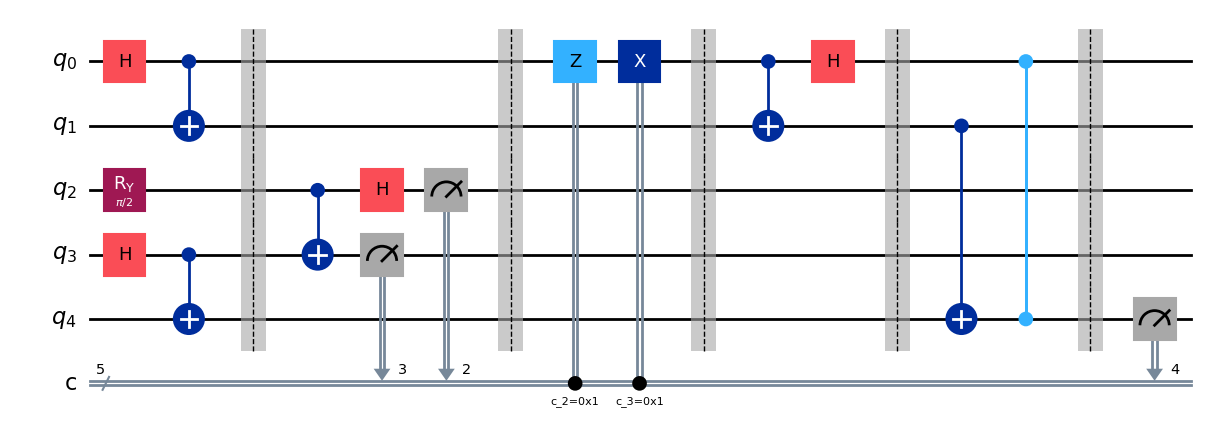

In [66]:
# Decode the information (You can use the custom function decode)
iqc.cx(0, 1)
iqc.h(0)
iqc.barrier()

# Apply the controlled operations on the qubit q4 by using the information from q0 and q1
iqc.cx(1, 4)
iqc.cz(0, 4)

iqc.barrier()

# Now q4 contains that arbitrary state. 
iqc.measure(4, 4)
iqc.draw("mpl")

After completing the quantum protocols, measurements are performed to extract the relevant information from the qubits. Each qubit is measured in the standard computational basis, and the results are recorded as classical bits.

The measurement results from Alice's qubits (q2 and q3) are encoded in q0 through superdense coding protocol and q0 is sent to Bob, Bob decodes the message and obtaining the 2 bits of classical information enabling him to apply the appropriate controlled operations to retrieve the arbitrary state on his qubit (q4), thus completing the teleportation protocol.

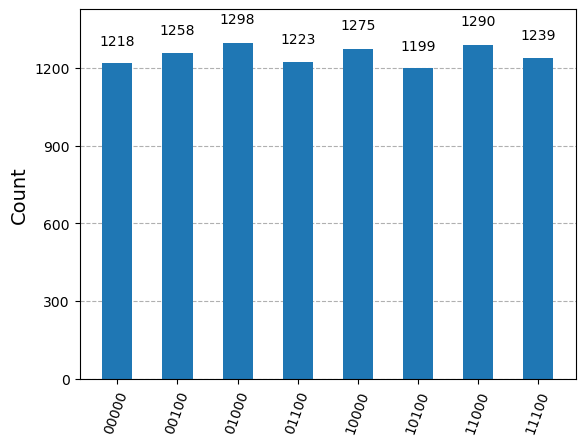

In [67]:
backend = Aer.get_backend("qasm_simulator")
results = backend.run(iqc, shots=10000).result()
count = results.get_counts()
plot_histogram(count)

To focus on Bob's final state (q4), the measurement results are reduced to marginal counts. Marginal counts extract the probabilities associated with a specific subset of qubits, disregarding the outcomes of the others. In this case, the marginal counts for q4 help verify whether the teleportation successfully reconstructed the original arbitrary state.

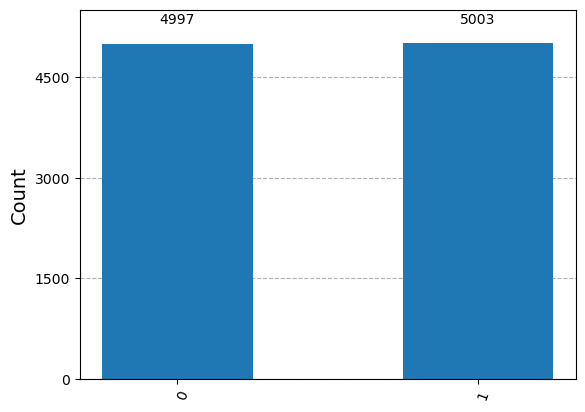

In [68]:
marginal_count = marginal_counts(count, [4])
plot_histogram(marginal_count)

### Determing the Polar Angle ($\theta$)
The polar angle $\theta$, which represents the angle made by the state vector with the Z-axis on the Bloch sphere, can be computed using the expectation value of the Z-operator ($\langle Z \rangle$). For a qubit in the general state $|\Psi\rangle = \cos(\theta/2) |0\rangle + e^{i \phi}\sin(\theta/2)|1\rangle$. the expectation value is given by:
$$\langle Z \rangle \hspace{1mm} = 0 \cdot \cos^2\Big(\frac{\theta}{2}\Big) + 1 \cdot \sin^2\Big(\frac{\theta}{2}\Big) = \sin^2\Big(\frac{\theta}{2}\Big)$$ \
Using the trigonometric identity: $$2 \cdot \sin^2\Big(\frac{\theta}{2}\Big) = 1 - \cos(\theta)$$
Rearranging this equation to solve for $\theta$: $$\theta = \arccos(1 - 2 \langle Z \rangle)$$
Through this process, we can determine the polar angle $\theta$, but the azimuthal angle $\phi$ remains undetermined. Therefore, the qubit state can be represented as a set of states with the same polar angle and varying azimuthal angles: $$|\Psi (\phi)\rangle = \set{(\theta, \phi) | \phi \in [0, 2\pi)}$$

In [69]:
# Compute the polar angle theta from the marginal count
# If theta is 0 or very close to 0, marginal_count["1"] may not exist, causing a KeyError.
# In such cases, theta is explicitly set to 0. This is reasonable, as for a sufficiently large 
# number of shots, a count of "1" should eventually appear unless theta is truly 0.
try:
    theta = np.arccos(1 - 2 * marginal_count["1"]/10000)
except:
    theta = 0
theta

1.5713963268308966

Using $\theta$, we compute the theoretical probabilities of measuring $\ket{0}$ and $\ket{1}$. Custom function `compute_probabilities` will perform this action.

In [70]:
def compute_probabilities(theta):
    """
    Computes and displays the probabilities of measuring |0⟩ and |1⟩
    for a given polar angle theta.

    Args:
        theta (float): The polar angle in radians.

    Displays:
        - Probability of measuring |0⟩: P(|0⟩)
        - Probability of measuring |1⟩: P(|1⟩)
    """
    # Compute the probability of measuring |0⟩
    prob_0 = np.cos(theta / 2)**2

    # Compute the probability of measuring |1⟩
    prob_1 = np.sin(theta / 2)**2

    # Display the probabilities in LaTeX format
    display(Math(f"P(|0⟩) = {prob_0:.4f}"))
    display(Math(f"P(|1⟩) = {prob_1:.4f}"))


In [71]:
# Evaluating the probability based on the polar angle.
compute_probabilities(theta)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Discussion: Why Combine Quantum Teleportation with Superdense Coding?
Quantum Teleportation alone requires two classical bits to transfer a single qubit's state, introducing a dependency on classical communication channels. By integrating Superdense Coding, which uses a qubit and an additional Bell pair to transfer two classical bits, the process becomes entirely quantum.

1. **Achieving Fully Quantum Communication**:
Combining Quantum Teleportation with Superdense Coding eliminates the need for classical channels, enabling the transfer of quantum and classical information entirely through quantum means. This makes the protocol inherently quantum.

2. **Efficient Use of Resources**:
The integration demonstrates the dual capabilities of entanglement. The same resource **Bell pairs** facilitates both classical (via Superdense Coding) and quantum (via Teleportation) information transfer, maximizing its utility.



#### **References**
[1. Nielsen, M. A., & Chuang, I. L. (2010). *Quantum Computation and Quantum Information*. Cambridge University Press.](https://books.google.co.in/books/about/Quantum_Computation_and_Quantum_Informat.html?id=aai-P4V9GJ8C&redir_esc=y)    

[2. Mosca, M. (2008). *Quantum Algorithms and Information*. University of Waterloo Lecture Series.](https://books.google.co.in/books/about/An_Introduction_to_Quantum_Computing.html?id=dQpREAAAQBAJ&redir_esc=y)  
 
[3. IBM Quantum Learning Resources:](https://learning.quantum.ibm.com/)  
> [Basics of Quantum Information](https://learning.quantum.ibm.com/course/basics-of-quantum-information) \
> [Fundamentals of Quantum Algorithms](https://learning.quantum.ibm.com/course/fundamentals-of-quantum-algorithms/quantum-query-algorithms) \
> [Variational Quantum Design](https://learning.quantum.ibm.com/course/variational-algorithm-design/variational-algorithms)